In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



# Imports

In [ ]:
import json
import math
import cv2
import PIL
from PIL import Image
import numpy as np
from keras import layers
from keras.layers import Layer, Lambda
from keras.applications import MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline

In [ ]:
import os
# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
# General packages
from IPython.display import display
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
# read images
import rasterio

In [ ]:
import gc
from random import randint

# Config Settings

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Variable Constants

In [ ]:
BATCH_SIZE = 16
TRAIN_VAL_RATIO = 0.20 
EPOCHS = 30
LR = 0.00010409613402110064

# Target & ID Loading

In [ ]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
test_df = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(10616, 4)
(3, 2)


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [ ]:
test_df.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


In [ ]:
gc.collect()

4

# Image Loading & Pre-processing

In [ ]:
def preprocess_image(image_path, desired_size=224):
    biopsy = openslide.OpenSlide(image_path)
    im = np.array(biopsy.get_thumbnail(size=(desired_size,desired_size)))
    im = Image.fromarray(im)
    im = im.resize((desired_size,desired_size)) 
    im = np.array(im)
    return im

In [ ]:
# get the number of training images from the target\id dataset
N = train_df.shape[0]
# create an empty matrix for storing the images
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)
# loop through the images from the images ids from the target\id dataset
# then grab the cooresponding image from disk, pre-process, and store in matrix in memory
for i, image_id in enumerate(tqdm(train_df['image_id'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/prostate-cancer-grade-assessment/train_images/{image_id}.tiff'
    )

100%|██████████| 10616/10616 [34:25<00:00,  5.14it/s] 


In [ ]:
if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    # do the same thing as the last cell but on the test\holdout set
    N = test_df.shape[0]
    x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)
    for i, image_id in enumerate(tqdm(test_df['image_id'])):
        x_test[i, :, :, :] = preprocess_image(
            f'../input/prostate-cancer-grade-assessment/test_images/{image_id}.tiff'
        )
else:
    print("test images not found")

test images not found


In [ ]:
# pre-processing the target (i.e. one-hot encoding the target)
y_train = pd.get_dummies(train_df['isup_grade']).values

print(x_train.shape)
print(y_train.shape)
if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    print(x_test.shape)
else:
    print("test images not found")

(10616, 224, 224, 3)
(10616, 6)
test images not found


In [ ]:
# Further target pre-processing

# Instead of predicting a single label, we will change our target to be a multilabel problem; 
# i.e., if the target is a certain class, then it encompasses all the classes before it. 
# E.g. encoding a class 4 retinopathy would usually be [0, 0, 0, 1], 
# but in our case we will predict [1, 1, 1, 1]. For more details, 
# please check out Lex's kernel.

y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 5] = y_train[:, 5]

for i in range(4, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
#print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [2892 2666 1343 1242 1249 1224]


# Train & Validation Split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.20, 
    random_state=2020
)

# Create Image Augmentation Generator

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

# Create Model

In [ ]:
from keras.applications import MobileNetV2
densenet = MobileNetV2(
    weights='../input/keras-pretrained-imagenet-weights/mobilenetv2_imagenet_1000_no_top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
def build_model(LR=LR):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.40))
    model.add(layers.Dense(6, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


# Train Model

In [ ]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val)
)

Epoch 1/30
128/128 [==============================] - 355s 3s/step - loss: 0.4629 - accuracy: 0.7765 - val_loss: 1.4515 - val_accuracy: 0.4706
Epoch 2/30
128/128 [==============================] - 334s 3s/step - loss: 0.4120 - accuracy: 0.8067 - val_loss: 1.1326 - val_accuracy: 0.6441
Epoch 3/30
128/128 [==============================] - 336s 3s/step - loss: 0.4028 - accuracy: 0.8110 - val_loss: 0.9012 - val_accuracy: 0.6894
Epoch 4/30
128/128 [==============================] - 333s 3s/step - loss: 0.3996 - accuracy: 0.8079 - val_loss: 0.8054 - val_accuracy: 0.6984
Epoch 5/30
128/128 [==============================] - 333s 3s/step - loss: 0.3888 - accuracy: 0.8185 - val_loss: 0.6851 - val_accuracy: 0.7207
Epoch 6/30
128/128 [==============================] - 335s 3s/step - loss: 0.3654 - accuracy: 0.8314 - val_loss: 0.6193 - val_accuracy: 0.7231
Epoch 7/30
128/128 [==============================] - 332s 3s/step - loss: 0.3816 - accuracy: 0.8189 - val_loss: 0.6223 - val_accuracy: 0.7428

# Training Plots

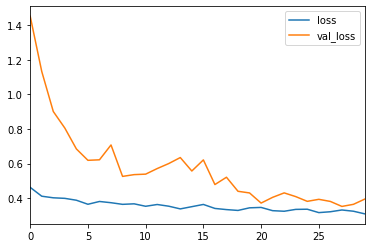

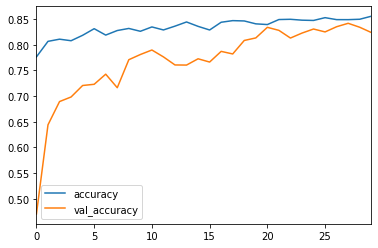

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

# Submission

In [ ]:
if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    print("test images found.")
    y_test = model.predict(x_test)
    y_test = y_test > 0.37757874193797547
    y_test = y_test.astype(int).sum(axis=1) - 1
    test_df['isup_grade'] = y_test
    test_df = test_df[["image_id","isup_grade"]]
    test_df.to_csv('submission.csv',index=False)
else: # if test is not available, just submit some random values
    print("test images not found, submitting random values.")
    rand_preds = []
    for i in range(len(test_df)):
        rand_preds.append(randint(0,5))
    test_df['isup_grade'] = rand_preds
    test_df = test_df[["image_id","isup_grade"]]
    test_df.to_csv('submission.csv',index=False)

test images not found, submitting random values.
